<a href="https://colab.research.google.com/github/mrazimi99/ImageClassification/blob/master/ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 lang="fa" dir="rtl" align=center>
طبقه بندی تصاویر
با شبکه عصبی چند لایه
</h1>
<h2 lang="fa" dir="rtl" align=center>
محمدرضا عظیمی
</h2>

<div lang="fa" dir="rtl">
<h2>
مقدمه
</h2>
<p>
میخواهیم با استفاده از شبکه های عصبی و آموزش دادن آن ها، دسته بندی تصاویر مختلف را انجام دهیم.
<br>
برای این کار نیاز است که شبکه ی عصبی خود را با تعداد لایه ها و نورون های متفاوتی آموزش دهیم و بهترین تعداد را برای لایه ها و نورون ها انتخاب کنیم.
<br>
از آنجاییکه با داشتن دو لایه ی میانی میتوان هر تابع غیر خطی ای را مدل کرد، آموزش را با دو لایه آغاز کرده و تمرکز خود را بر تعداد نورون ها می گذاریم.
</p>

<p>
در این قسمت ابتدا package
های مورد نیاز را import می کنیم.
<br>
همچنین در این پروژه از ابزار موجود در pytorch
استفاده خواهیم کرد.
</p>
</div>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from random import sample
import numpy as np
import matplotlib.pyplot as plt
import math

from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

from sklearn.model_selection import train_test_split

import time
from datetime import timedelta
from datetime import datetime

import os.path

<div lang="fa" dir="rtl">
<h2>
بارگیری داده ها
</h2>
<p>
ابتدا داده های مورد نیاز برای train و test
را بارگیری می کنیم.
<br>
برای کمینه کردن تعداد دفعات دانلود در اجراهای مختلف، ابتدا وجود پوشه ی تصاویر را بررسی کرده و درصورت عدم وجود، آن را بارگیری می کنیم.
</p>
</div>

In [2]:
if not os.path.isdir("categorized_products"):
    !gdown --id "1aFjcSk9hBzsHusrjO3UjCg4xQo9Ubdr1"
    !unzip "categorized_products"

<div lang="fa" dir="rtl">
<p>
در این قسمت کلاس CustomToTensor را 
پیاده سازی کرده و عملگر پرانتز را برای آن overload
می کنیم.
<br>
این تابع تصویر را دریافت کرده و آن را بصورت یک Tensor
و بدون scale کردن برمی گرداند.
</p>
</div>

In [3]:
class CustomToTensor(object):
    def __call__(self, image):
        image = np.array(image, dtype=np.float32)
        return torch.from_numpy(image)

<div lang="fa" dir="rtl">
<p>
با استفاده از تابع Compose
می توان تبدیل های مختلفی را بر روی مجموعه داده اعمال کرد.
<br>
در این قسمت دو تبدیل را بر روی تصاویر اعمال می کنیم.
<br>
برای هر تصویر ابتدا آن را در محدوده سیاه و سفید برده و سپس به Tensor
تبدیل می کنیم.
<br>
حال تابع ImageFolder
را فراخوانی کرده و پوشه ی داده ها و نیز object ساخته شده
برای تبدیل هر تصویر را بعنوان ورودی به آن می دهیم.
<br>
همچنین کلاس های موجود در مجموعه ی داده را گرفته و در متغیر classes
برای استفاده های بعدی ذخیره می کنیم.
</p>
</div>

In [4]:
transform = transforms.Compose([transforms.Grayscale(), CustomToTensor()])
dataset = ImageFolder("categorized_products" , transform=transform)
classes = dataset.classes

<div lang="fa" dir="rtl">
<h2>
بخش اول
</h2>
<p>
برای اطمینان از صحت عملکرد خود تا به اینجای کار، تابعی برای نمایش تعدادی از عکس ها می نویسیم.
<br>
این تابع لیستی از تصاویر و کلاس متناظرشان را گرفته و آن ها را در سه ردیف چهارتایی به نمایش می گذارد.
<br>
از آنجاییکه تبدیل سیاه و سفید را روی این تصاویر انجام داده بودیم، خروجی شامل تصاویر سیاه و سفید خواهد بود.
<br>
در نهایت 12 مورد از تصاویر موجود در مجموعه داده را انتخاب کرده و آن هارا به این تابع می دهیم تا نتیجه ی کار خود را مشاهده کنیم.
</p>
</div>

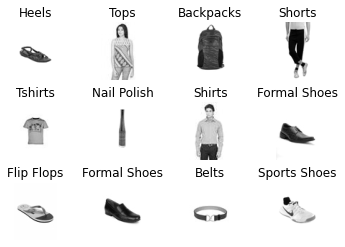

In [5]:
def imshow(img_array, labels, classes):
    _, axs = plt.subplots(3, 4) 
    for i in range(3):
      for j in range(4):
        axs[i][j].imshow(img_array[i * 4 + j], cmap='gray')
        axs[i][j].set_title(classes[labels[i * 4 + j]])
        axs[i][j].axis('off')
    plt.subplots_adjust(hspace=0.4)
    plt.show()

elements = sample(list(dataset), 12)
images = [elem[0] for elem in elements]
labels = [elem[1] for elem in elements]

imshow(images, labels, classes)

<div lang="fa" dir="rtl">
<h2>
بخش دوم
</h2>
<h3>
الف
</h3>
<p>
در این قسمت می خواهیم نحوه ی توزیع تصاویر در انواع محصولات را مشاهده کنیم.

برای این منظور تابعی را تعریف می کنیم که loader
مربوطه و نیز نام کلاس های مختلف را بعنوان ورودی گرفته و نمودار توزیع تصاویر در دسته های مختلف را بصورت نزولی رسم می کند.
</p>
</div>

In [6]:
def plot_image_distribution(loader, classes):
    total_category_count = {class_ : 0 for class_ in classes}

    for _, labels in loader:
        total_category_count[ classes[labels] ] += 1

    sorted_classes = list({k: v for k, v in reversed(sorted(total_category_count.items(), key=lambda item: item[1]))}.items())
    x, y = zip(*sorted_classes)
    fig=plt.figure(figsize=(30, 9), dpi= 80, facecolor='w', edgecolor='k')
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams.update({'font.size': 12})
    plt.bar(x, y)
    plt.gca().set_xlim(xmin=-0.5, xmax=len(sorted_classes))
    plt.title("Each Category's Frequency", fontweight="bold")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, max(total_category_count.values()) + 200, 200.0))
    plt.xlabel("Category")
    plt.ylabel("Frequency")
    plt.show()

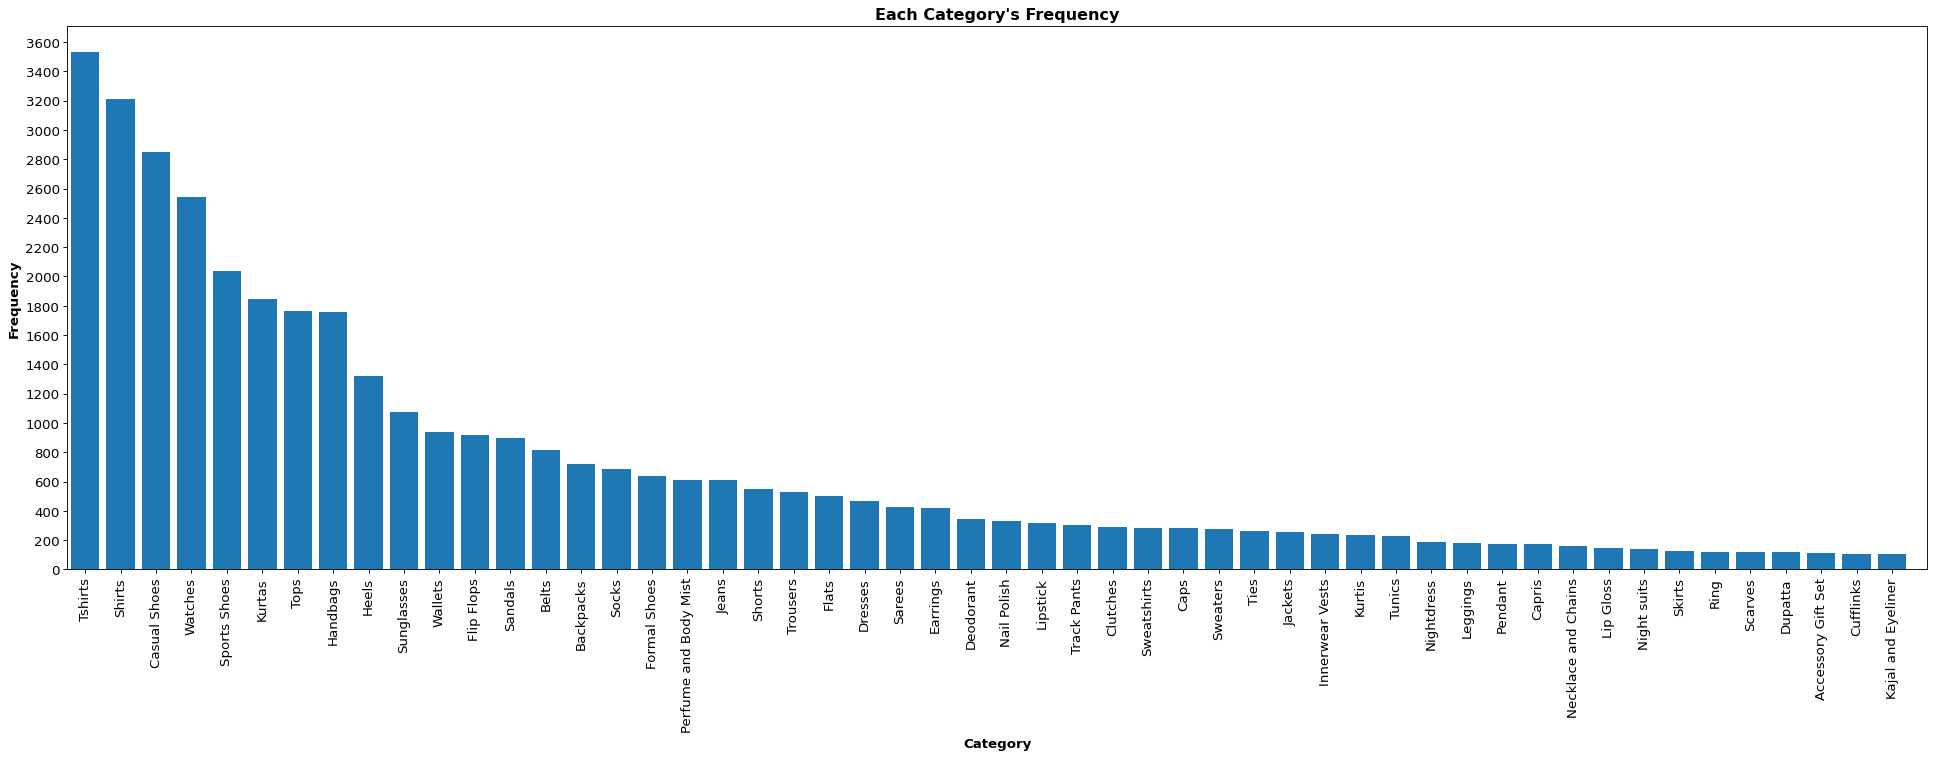

In [7]:
plot_image_distribution(list(dataset), classes)

<div lang="fa" dir="rtl">
<h2>
بخش دوم
</h2>
<h3>
الف
</h3>
<p>
همانطور که در نمودار مشاهده می کنیم، بیشترین تراکم در دسته ی Tshirts و کمترین تراکم
در دسته ی Kajal and Eyeliner
قرار دارد.

تفاوت تعداد تصاویر بین این دو کلاس بسیار زیاد است و همانطور که در نمودار مشاهده می شود، توزیع تصاویر در میان دسته ها بسیار نامتوازن است.

برای رفع این مشکل و متوازن کردن توزیع داده ها می توان از روش های oversampling استفاده کرد.
</p>
</div>

<div lang="fa" dir="rtl">
<h3>
ب
</h3>
<p>
در این بخش می خواهیم مجموعه ی داده ها را به دو دسته ی تست و آموزش تقسیم کنیم.

این کار باید بصورت تصادفی انجام شود و جداسازی طوری باشد که از هر دسته بطور تصادفی 20 درصد آن در مجموعه داده های تست و 80 درصد آن در مجموعه داده های آموزش قرار گیرد.

برای این کار از تابع train_test_split
موجود در کتابخانه ی scikit
استفاده می کنیم.

این تابع مجموعه داده ها و نسبت سهم داده های تست (و یا آموزش) به کل داده ها (که در اینجا برای داده های تست 20 درصد است) را بعنوان ورودی گرفته و آن ها را طوری به دو دسته تقسیم می کند که از هر کلاس موجود، نسبت یکسانی انتخاب شود.

این کار بر اساس آرایه ی برچسب ها که بعنوان پارامتر stratify
به تابع پاس دادیم انجام می شود.
</p>
</div>

In [8]:
labels = [elem[1] for elem in dataset]
validation_split = 0.2
train_all, test_all, Y_train, Y_test = train_test_split(dataset, labels, test_size=validation_split, random_state=42, stratify=labels)

<div lang="fa" dir="rtl">
<h2>
بخش سوم
</h2>
<p>
در این بخش می خواهیم یک مدل شبکه عصبی چند لایه را پیاده سازی کرده و سپس آن را بر روی تصاویر fit کنیم.

ابتدا با استفاده از توابع pytroch
و داده های آموزش و تست که آن ها را در بخش قبلی جدا کردیم، Data Loader ها را
برای هر کدام از مجموعه داده های آموزش و تست می سازیم.

در ابتدا اندازه ی batch size
را برابر 64 قرار می دهیم.
</p>
</div>

In [9]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_all, batch_size=batch_size, num_workers=16)
test_loader = torch.utils.data.DataLoader(test_all, batch_size=batch_size, num_workers=16)

<div lang="fa" dir="rtl">
<p>
اکنون کلاس Model
را پیاده سازی می کنیم.

این کلاس از کلاس nn.Module
ارث بری می کند. در حقیقت برای ساختن یک مدل می بایست آن را فرزند کلاس nn.Module
قرار داده و سپس لایه های شبکه ی خود را طراحی کرده و تابع forward
را برای آن override
کنیم.

کلاسی که تعریف می کنیم، در هنگام ساخته شدن، تعداد نورون های لایه های میانی شبکه، activation function و تعداد
نورون های لایه های ورودی و خروجی را می گیرد و لایه های شبکه را می سازد.
</p>
</div>

In [10]:
class Model(nn.Module):
    def __init__(self, input_num, middle_layers, output_num, act):
        super(Model, self).__init__()
        self.layers = nn.ModuleList()
        self.acts = []

        self.layers.append(nn.Linear(input_num, middle_layers[0]))
        self.acts.append(act)

        for i in range(len(middle_layers) - 1):
            self.layers.append(nn.Linear(middle_layers[i], middle_layers[i + 1]))
            self.acts.append(act)

        self.layers.append(nn.Linear(middle_layers[-1], output_num))

    def forward(self, x):

        x = x.view(x.size(0), -1)

        for i in range(len(self.layers) - 1):
            x = self.layers[i](x)
            x = self.acts[i](x)

        x = self.layers[-1](x)
        return x

<div lang="fa" dir="rtl">
<p>
حال چون از منابع GPU ای که
colab
در اختیارمان می گذارد استفاده می کنیم، پارامتر device
برای مدل خود را به cuda تنظیم می کنیم
تا از GPU به خوبی استفاده شود.
</p>
</div>

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
print(device)

cuda:0


<div lang="fa" dir="rtl">
<p>
در این قسمت توابعی برای fit کردن مدل و نیز
تست کردن آن تعریف میکنیم تا در آینده و برای بررسی و مقایسه ی حالات مختلف، فقط پارامترها را تغییر داده و توابع مورد نیاز را صرفا صدا بزنیم.
</p>
</div>

In [13]:
def fit(model, train_loader, device, criterion, optimizer, num_epochs=10):
    total_time = 0.
    loss_per_epoch = {e + 1 : 0 for e in range(num_epochs)}

    for epoch in range(num_epochs):
        train_loss = 0.
        d1 = datetime.now()

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()

            # Forward pass to get output/logits
            outputs = model(images)

            # Calculate Loss: softmax --> cross entropy loss
            loss = criterion(outputs, labels)

            # Getting gradients w.r.t. parameters
            loss.backward()

            # Updating parameters
            optimizer.step()
            train_loss += loss.item()

        average_loss = train_loss / len(train_loader)
        d2 = datetime.now()
        delta = d2 - d1
        seconds = float(delta.total_seconds())
        total_time += seconds
        loss_per_epoch[epoch + 1] = average_loss
        print('epoch %d, train_loss: %.3f, time elapsed: %s seconds' % (epoch + 1, average_loss, seconds))

    if math.isnan(max(loss_per_epoch.values())):
        print('Could not plot for nan losses.')
    else:
        plt.plot(list(loss_per_epoch.keys()), list(loss_per_epoch.values()))
        plt.title('Avreage Loss Per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Aerage Loss')
        plt.xlim(1, num_epochs + 1)
        plt.ylim(0, max(loss_per_epoch.values()) + 1)
        plt.show()

    print('total training time: %.3f minutes' % (total_time / 60))

In [14]:
def test_model_accuracy(model, test_loader, classes):
    # Calculate Accuracy         
    correct = 0.
    total = 0.
    correct_predicted = {id : 0 for id in range(len(classes))}
    num_of_labels = {id : 0 for id in range(len(classes))}

    # Iterate through test dataset
    with torch.no_grad():
      for images, labels in test_loader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        for p, l in zip(predicted, labels):
            num_of_labels[l.item()] += 1

            if p == l:
                correct_predicted[p.to('cpu').item()] += 1

        correct += (predicted.to('cpu') == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy: {}%'.format(accuracy))
    return [x / y for x, y in zip(correct_predicted.values(), num_of_labels.values())]

In [15]:
def analyse(model, train_loader, test_loader, classes):
    print('Train ', end='')
    train_accs = test_model_accuracy(model, train_loader, classes)
    print('Test ', end='')
    test_accs = test_model_accuracy(model, test_loader, classes)
    plt.figure(figsize=(30, 9), dpi= 80, facecolor='w', edgecolor='k')
    plt.bar([i - 0.1 for i in range(len(classes))], train_accs, width=0.2, label='Train')
    plt.bar([i + 0.1 for i in range(len(classes))], test_accs, width=0.2, label='Test')
    plt.legend()
    plt.xlim(-0.2, len(classes))
    plt.xticks(list(range(len(classes))), classes, rotation='vertical')
    plt.title('Comparision Between Test and Train Accuracies')
    plt.xlabel('Category')
    plt.ylabel('Accuracy')
    plt.show()

<div lang="fa" dir="rtl">
<p>
اکنون یک شی از کلاس مدل می سازیم.

برای شروع تعداد لایه ها را دو لایه انتخاب کرده و تعداد نورون ها را خیلی زیاد نمی کنیم.

همچنین device
را برای مدل خود تنظیم می کنیم.
</p>
</div>

In [16]:
image_size = 60 * 80
model = Model(image_size, [2000, 700, 100] , len(classes), F.relu)
model = model.to(device)

<div lang="fa" dir="rtl">
<p>
مقدار پیش فرض برای نرخ یادگیری را برابر 0.01 می گذاریم.

همچنین تابع هزینه ای که به طور پیش فرض استفاده می کنیم، Cross Entropy است.

بعنوان بهینه ساز نیز از بهینه ساز Stochastic Gradient Descent
بطور پیش فرض استفاده خواهیم کرد.
</p>
</div>

In [17]:
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

<div lang="fa" dir="rtl">
<h3>
الف
</h3>
<p>
در این قسمت می خواهیم تعداد وزن های شبکه در هر لایه و نیز در کل شبکه را بدست آوریم.

این کار را با استفاده از تابع numel برای هر کدام از لایه ها و نیز نورون های بایاس بدست می آوریم.

تعداد وزن های هر لایه از حاصل ضرب (تعداد نورون های لایه ی قبل + 1) در تعداد نورون های لایه ی بعد) بدست می اید.

اضافه کردن عدد یک برای در نظر گرفتن گره بایاس بود.

بنابراین انتظار داریم که تعداد وزن های مدل اولیه ی ما بصورت زیر باشد:
</p>
</div>

4801 * 2000 + 2001 * 700 + 701 * 100 + 101 * 52

= 9602000 + 1400700 + 70100 + 5252

= 11078052



In [18]:
total_params = [param.numel() for param in model.parameters() if param.requires_grad]
print(total_params, ',', 'Sum:', sum(total_params))

[9600000, 2000, 1400000, 700, 70000, 100, 5200, 52] , Sum: 11078052


<div lang="fa" dir="rtl">
<h3>
ب
</h3>
<p>
حال مدل را بر روی تصاویر fit می کنیم.

این کار را با استفاده از تابع fit که پیش تر آن را تعریف کرده بودیم انجام می دهیم.

این تابع مقدار train loss
را در هر epoch
چاپ کرده و نیز در نهایت نمودار تغییرات آن در هر epoch را رسم می کند.
</p>
</div>

In [19]:
fit(model, train_loader, device, criterion, optimizer, num_epochs=10)

epoch 1, train_loss: nan, time elapsed: 4.466169 seconds
epoch 2, train_loss: nan, time elapsed: 4.209218 seconds
epoch 3, train_loss: nan, time elapsed: 4.237564 seconds
epoch 4, train_loss: nan, time elapsed: 4.218675 seconds
epoch 5, train_loss: nan, time elapsed: 4.244244 seconds
epoch 6, train_loss: nan, time elapsed: 4.237148 seconds
epoch 7, train_loss: nan, time elapsed: 4.2244 seconds
epoch 8, train_loss: nan, time elapsed: 4.270106 seconds
epoch 9, train_loss: nan, time elapsed: 4.271517 seconds
epoch 10, train_loss: nan, time elapsed: 4.223356 seconds
Could not plot for nan losses.
total training time: 0.710 minutes


<div lang="fa" dir="rtl">
<p>
همانطور که مشاهده می کنیم مقدار train loss
به قدری زیاد بوده که قابل نمایش نبوده و مقدار آن در تمامی epoch
ها nan
است.

این اتفاق می تواند به این دلیل باشد که learning rate
ما بسیار بالاست و دقت کافی را در تشخیص های خود نداریم.

همچنین از دیگر دلایل می تواند محدوده ی ورودی باشد که در اینجا صفر تا 255 است؛
اما بهتر است که این محدوده بین 0 تا 1 باشد.

تعداد لایه ها و نورون های شبکه نیز می تواند موثر باشد.

این مورد را در قسمت های بعد بررسی خواهیم کرد.
</p>
</div>

Train Accuracy: 0.29866774052820566%
Test Accuracy: 0.2953020134228188%


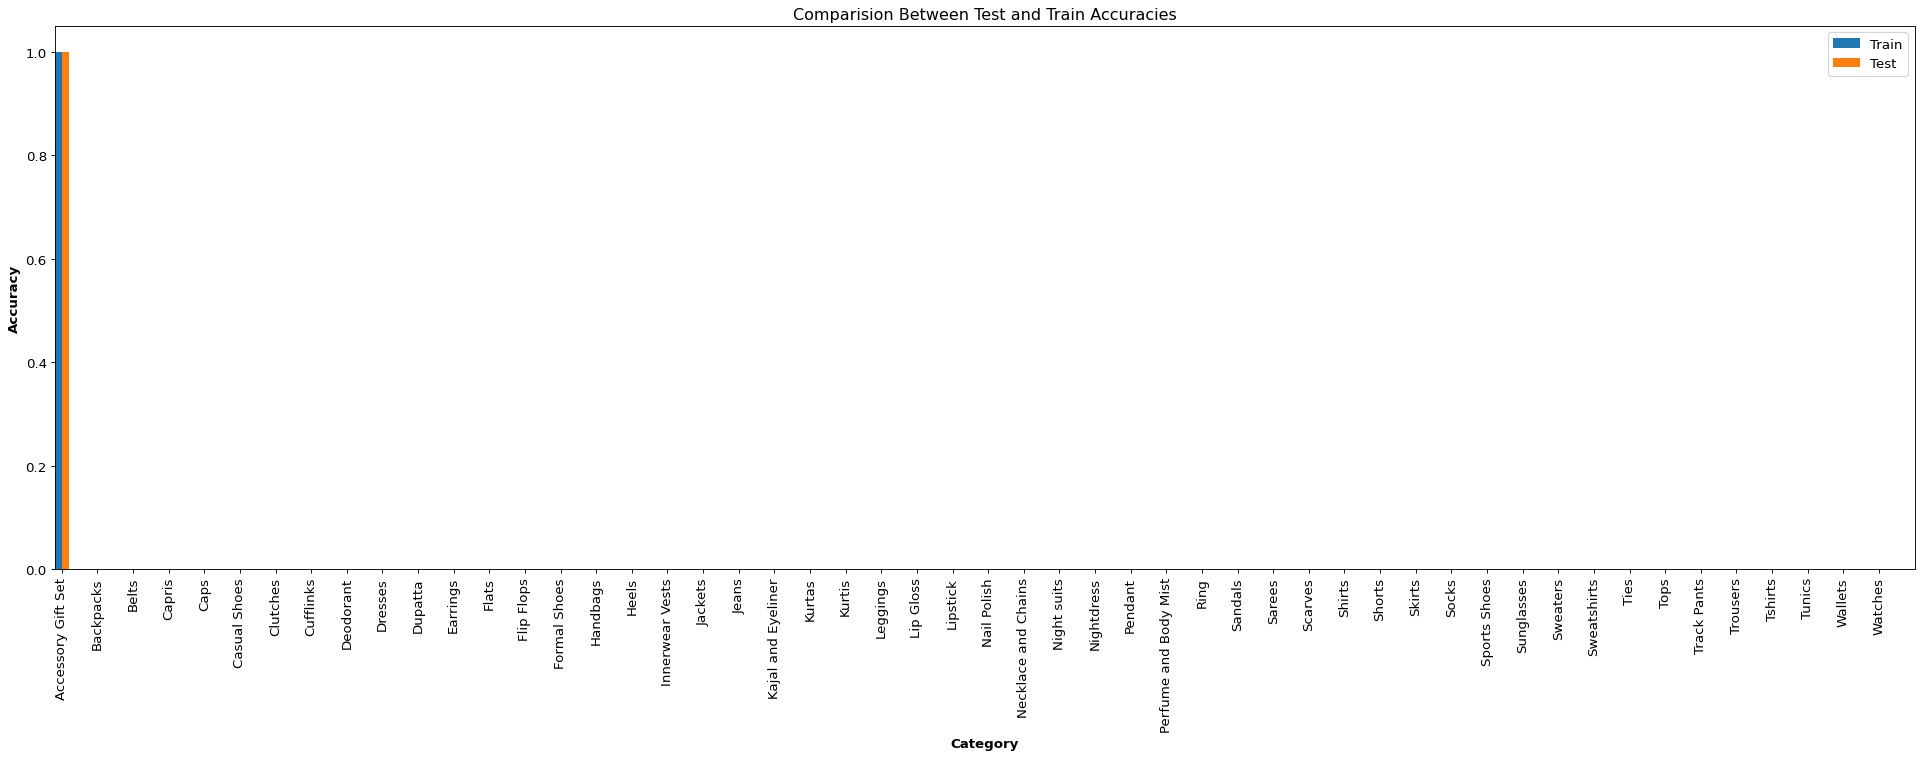

In [20]:
analyse(model, train_loader, test_loader, classes)